In [1]:
from qboard import Solver

# useful additional packages
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import numpy as np
import networkx as nx
import retworkx as rx

from qiskit import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp, ExactCover
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer, GroverOptimizer
from qiskit_optimization.problems import QuadraticProgram

In [2]:
mode = "remote:simcim"
#mode = "remote:dwave"

# Access parameters
PARAMS = {
"remote_addr": "https://remote.qboard.tech", 
"access_key": "b229d784-53e5-41e0-98c3-0aeea3c76a51"
}

# Solver initialization
s = Solver(mode="remote:simcim", params=PARAMS) 

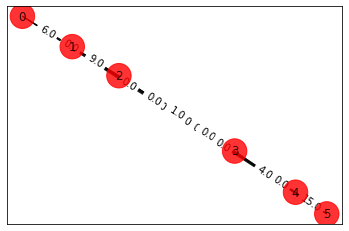

In [3]:
n=6 # Number of nodes in graph
G=nx.Graph()
G.add_nodes_from(np.arange(0,n,1))
elist=[(0,1,6.0),(1,2,9.0),(2,3,1.0),(3,4,4.0),(4,5,15.0)
       ,(0,2,0.0),(0,3,0.0),(0,4,0.0),
       (1,3,0.0),(1,4,0.0),(1,5,0.0),
       (2,0,0.0),(2,4,0.0),(2,5,0.0),
       (3,0,0.0),(3,5,0.0),
       (4,0,0.0),(4,2,0.0),
       (5,0,0.0),(5,1,0.0),(5,2,0.0),(5,3,0.0)]

G.add_weighted_edges_from(elist)

colors = ['r' for node in G.nodes()]
pos = nx.spring_layout(G)

def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

draw_graph(G, colors, pos)

In [4]:
# Computing the weight matrix from the random graph
w = np.zeros([n,n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i,j,default=0)
        if temp != 0:
            w[i,j] = temp['weight']
print(w)

[[ 0.  6.  0.  0.  0.  0.]
 [ 6.  0.  9.  0.  0.  0.]
 [ 0.  9.  0.  1.  0.  0.]
 [ 0.  0.  1.  0.  4.  0.]
 [ 0.  0.  0.  4.  0. 15.]
 [ 0.  0.  0.  0. 15.  0.]]


In [5]:
# Расчёт без квантового компьютера
best_cost_brute = 0
for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost = 0
    for i in range(n):
        for j in range(n):
            cost = cost + w[i,j]*x[i]*(1-x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x
    print('case = ' + str(x)+ ' cost = ' + str(cost))
    
colors = ['r' if xbest_brute[i] == 0 else 'c' for i in range(n)]
#draw_graph(G, colors, pos)

print('\nBest solution = ' + str(xbest_brute) + ' cost = ' + str(best_cost_brute))


case = [0, 0, 0, 0, 0, 0] cost = 0.0
case = [1, 0, 0, 0, 0, 0] cost = 6.0
case = [0, 1, 0, 0, 0, 0] cost = 15.0
case = [1, 1, 0, 0, 0, 0] cost = 9.0
case = [0, 0, 1, 0, 0, 0] cost = 10.0
case = [1, 0, 1, 0, 0, 0] cost = 16.0
case = [0, 1, 1, 0, 0, 0] cost = 7.0
case = [1, 1, 1, 0, 0, 0] cost = 1.0
case = [0, 0, 0, 1, 0, 0] cost = 5.0
case = [1, 0, 0, 1, 0, 0] cost = 11.0
case = [0, 1, 0, 1, 0, 0] cost = 20.0
case = [1, 1, 0, 1, 0, 0] cost = 14.0
case = [0, 0, 1, 1, 0, 0] cost = 13.0
case = [1, 0, 1, 1, 0, 0] cost = 19.0
case = [0, 1, 1, 1, 0, 0] cost = 10.0
case = [1, 1, 1, 1, 0, 0] cost = 4.0
case = [0, 0, 0, 0, 1, 0] cost = 19.0
case = [1, 0, 0, 0, 1, 0] cost = 25.0
case = [0, 1, 0, 0, 1, 0] cost = 34.0
case = [1, 1, 0, 0, 1, 0] cost = 28.0
case = [0, 0, 1, 0, 1, 0] cost = 29.0
case = [1, 0, 1, 0, 1, 0] cost = 35.0
case = [0, 1, 1, 0, 1, 0] cost = 26.0
case = [1, 1, 1, 0, 1, 0] cost = 20.0
case = [0, 0, 0, 1, 1, 0] cost = 16.0
case = [1, 0, 0, 1, 1, 0] cost = 22.0
case = [0, 1, 0, 1,

In [6]:
tsp = Tsp.create_random_instance(n, seed=123)
tsp.graph.graph = G.graph
qp = tsp.to_quadratic_program()
print(qp.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: TSP

Minimize
 obj: [ 96 x_0_0*x_1_1 + 96 x_0_0*x_1_5 + 182 x_0_0*x_2_1 + 182 x_0_0*x_2_5
      + 66 x_0_0*x_3_1 + 66 x_0_0*x_3_5 + 170 x_0_0*x_4_1 + 170 x_0_0*x_4_5
      + 52 x_0_0*x_5_1 + 52 x_0_0*x_5_5 + 96 x_0_1*x_1_0 + 96 x_0_1*x_1_2
      + 182 x_0_1*x_2_0 + 182 x_0_1*x_2_2 + 66 x_0_1*x_3_0 + 66 x_0_1*x_3_2
      + 170 x_0_1*x_4_0 + 170 x_0_1*x_4_2 + 52 x_0_1*x_5_0 + 52 x_0_1*x_5_2
      + 96 x_0_2*x_1_1 + 96 x_0_2*x_1_3 + 182 x_0_2*x_2_1 + 182 x_0_2*x_2_3
      + 66 x_0_2*x_3_1 + 66 x_0_2*x_3_3 + 170 x_0_2*x_4_1 + 170 x_0_2*x_4_3
      + 52 x_0_2*x_5_1 + 52 x_0_2*x_5_3 + 96 x_0_3*x_1_2 + 96 x_0_3*x_1_4
      + 182 x_0_3*x_2_2 + 182 x_0_3*x_2_4 + 66 x_0_3*x_3_2 + 66 x_0_3*x_3_4
      + 170 x_0_3*x_4_2 + 170 x_0_3*x_4_4 + 52 x_0_3*x_5_2 + 52 x_0_3*x_5_4
      + 96 x_0_4*x_1_3 + 96 x_0_4*x_1_5 + 182 x_0_4*x_2_3 + 182 x_0_4*x_2_5
      + 66 x_0_4*x_3_3 + 66 x_0_4*x_3_5 + 170 x_0_4*x_4_3 + 170 x_0_4*x_4_5

In [7]:
from qiskit_optimization.converters import QuadraticProgramToQubo

qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
print(qubo)
qubitOp, offset = qubo.to_ising()
print('Offset:', offset)
print('Ising Hamiltonian:')
print(str(qubitOp))

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: TSP

Minimize
 obj: - 44980 x_0_0 - 44980 x_0_1 - 44980 x_0_2 - 44980 x_0_3 - 44980 x_0_4
      - 44980 x_0_5 - 44980 x_1_0 - 44980 x_1_1 - 44980 x_1_2 - 44980 x_1_3
      - 44980 x_1_4 - 44980 x_1_5 - 44980 x_2_0 - 44980 x_2_1 - 44980 x_2_2
      - 44980 x_2_3 - 44980 x_2_4 - 44980 x_2_5 - 44980 x_3_0 - 44980 x_3_1
      - 44980 x_3_2 - 44980 x_3_3 - 44980 x_3_4 - 44980 x_3_5 - 44980 x_4_0
      - 44980 x_4_1 - 44980 x_4_2 - 44980 x_4_3 - 44980 x_4_4 - 44980 x_4_5
      - 44980 x_5_0 - 44980 x_5_1 - 44980 x_5_2 - 44980 x_5_3 - 44980 x_5_4
      - 44980 x_5_5 + [ 44980 x_0_0^2 + 44980 x_0_0*x_0_1 + 44980 x_0_0*x_0_2
      + 44980 x_0_0*x_0_3 + 44980 x_0_0*x_0_4 + 44980 x_0_0*x_0_5
      + 44980 x_0_0*x_1_0 + 96 x_0_0*x_1_1 + 96 x_0_0*x_1_5 + 44980 x_0_0*x_2_0
      + 182 x_0_0*x_2_1 + 182 x_0_0*x_2_5 + 44980 x_0_0*x_3_0 + 66 x_0_0*x_3_1
      + 66 x_0_0*x_3_5 + 44980 x_0_0*x_4_0 + 170 x_0_0*x_4_1 + 170 x_0_0

In [8]:
# QUBO matrix definition
#print(str(qubitOp))
Q = w #np.random.randn(5,5)
print('QUBO-матрица:',Q)

# Getting results
spins, energy = s.solve_qubo(Q, timeout=30)
print(s.h)

QUBO-матрица: [[ 0.  6.  0.  0.  0.  0.]
 [ 6.  0.  9.  0.  0.  0.]
 [ 0.  9.  0.  1.  0.  0.]
 [ 0.  0.  1.  0.  4.  0.]
 [ 0.  0.  0.  4.  0. 15.]
 [ 0.  0.  0.  0. 15.  0.]]
[2021-10-23 19:30:20] Solver remote:simcim started
[2021-10-23 19:30:21] Server status - 0 active tasks
[2021-10-23 19:30:21] Start matrix upload
[2021-10-23 19:30:21] Upload completed, start solving
[2021-10-23 19:30:29] Found solution 1488735355279105777652263907513985925120.000000 
[2021-10-23 19:30:54] Solver completed, solution type - feasible 
[2021-10-23 19:30:54] Solution stored to cache (new best entry)
[3.  7.5 5.  2.5 9.5 7.5]
